2

## Objective
This notebook runs some basic commands to get familiar with jupyter.
Later, we will create a model for image recognition -- Dogs vs Cats

In [1]:
1+1

2

In [1]:
name = 'Anil'

In [4]:
name

'Anil'

In [1]:
%matplotlib inline

In [2]:
path = "data/dogscats/sample/"
#path = "data/dogscats/"

In [3]:
#libraries
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [4]:
import utils
from utils import plots


import vgg16; reload(vgg16)
from vgg16 import Vgg16

Using Theano backend.


In [5]:
batch_size=50

In [6]:
from vgg16 import Vgg16


vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 1977 images belonging to 2 classes.
Found 289 images belonging to 2 classes.
Epoch 1/1
1977/1977 [==============================] - 849s - loss: 0.1974 - acc: 0.9454 - val_loss: 0.0577 - val_acc: 0.9758


Found 1977 images belonging to 2 classes.


In [8]:
imgs,labels = next(batches)

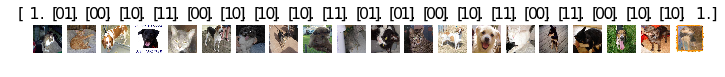

In [9]:
plots(imgs, titles=labels)

In [10]:
vgg.predict(imgs, True)

(array([ 0.9997,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  0.9914,  0.9994,  1.    ,  1.    ,
         1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  0.9905,  1.    ,  1.    ,  1.    ], dtype=float32),
 array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]),
 ['cats',
  'cats',
  'dogs',
  'dogs',
  'cats',
  'dogs',
  'dogs',
  'dogs',
  'dogs',
  'cats',
  'cats',
  'cats',
  'dogs',
  'dogs',
  'cats',
  'dogs',
  'cats',
  'dogs',
  'dogs',
  'dogs'])

## Building the model from scratch
For the rest of this tutorial, we will not be using the Vgg16 class at all. Instead, we will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if you want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going on behind the scenes.

In [1]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Using Theano backend.


In [4]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [7]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

## Model

In [8]:
## convolution block
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [9]:
## fully connected dense block
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [10]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [11]:
## model
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

Convolution layers are for finding patterns in images
Dense (fully connected) layers are for combining patterns across an image
Now that we've defined the architecture, we can create the model like any python object: